<a href="https://colab.research.google.com/github/aquila00/user_based/blob/main/movieit_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação usando SVD



##Métodos de Recomendação usando Fatores Latentes

Um dos mais eficientes métodos de recomendação são os Métodos de Fatores Latentes, neles os valores estão "escondidos", ou seja, não são diretamente observáveis.

O princípio deste método é baseado em álgebra linear, mais especificamente na Transformada de Fourrier, que realiza a redução de dimensionalidade, criando um novo espaço de recursos, com poucas perdas, possibilitando cálculos mais rápidos em tempo real.

-Princípio resumido da Transformada de Fourrier 

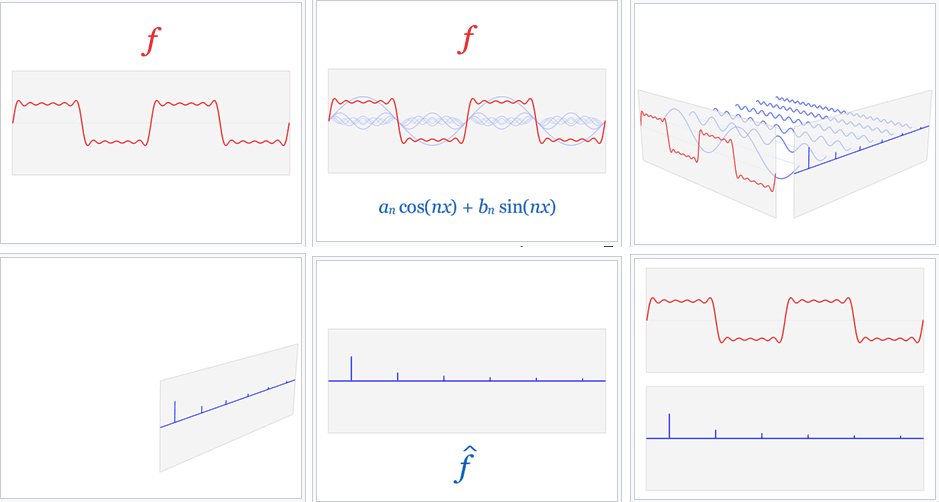


##SVD - Singular Value Decomposition


O SVD é um método de de fatoração matricial em que uma matriz **A** pode ser decomposta em três matrizes, de acordo com o Teorema:



$A = U\Sigma V^T$

onde:

$A =$ é a matriz de dados

$\Sigma =$ é matriz diagonal
- se e somente se

$S  V =$ são matrizes unitárias ou ortogonais
- se e somente se

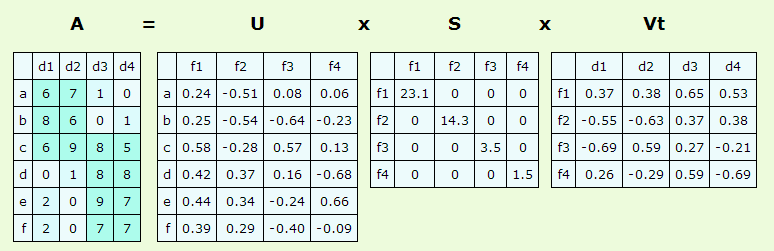

# biblioteca Scikit-Surprise

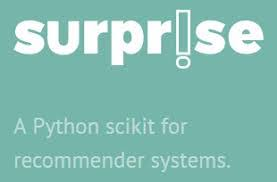


#Importando Bibliotecas

In [ ]:
!pip install scikit-surprise -q

# importando bibliotecas gerais
import numpy as np
import pandas as pd
from typing import * #(rodar o dict)

# importando bibliotecas para o cálculo de destância entre os usuários
import operator
from scipy.spatial.distance import cosine

# bibliotecas KNN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# biblioteca para o RMSE
from sklearn.metrics import mean_squared_error

# biblioteca SVD surprise (netflix)
from surprise import Dataset, SVD, Reader, accuracy, AlgoBase
from surprise.model_selection import cross_validate, train_test_split

# google drive / colab
from google.colab import drive

In [ ]:
# Acessando os arquivos no GoogleDrive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Importando Base de dados

In [ ]:
path = '/content/gdrive/MyDrive/recomendation_movies/ml-100k'

# importação dos arquivos de dados e atribuição de nomes às colunas
#informações do database
db_info = pd.read_csv(f'{path}/u.info', header = None)
#avaliações dos filmes
db_rating = pd.read_csv(f'{path}/u.data', sep='\t', names = ['userid', 'movieid', 'rating', 'timestamp'])
#perfil dos usuários
db_user = pd.read_csv(f'{path}/u.user', sep='\t', names = ['userid', 'age', 'gender', 'ocupation', 'zipcode'])
#listagem das ocupações
db_user_occupation = pd.read_csv(f'{path}/u.occupation', sep='|')
#listagem dos gênero possíveis para os filmes
db_movie_genre = pd.read_csv(f'{path}/u.genre', sep='|')
#listagem dos filmes quanto aos seus gêneros
db_movie = pd.read_csv(f'{path}/u.item', sep='|', names=['movieid', 'movietitle',
                        'releasedate', 'videoreleasedate', 'IMDbURL', 'unknown',
                        'Action', 'Adventure', 'Animation', 'Childrens',
                        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                        'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')

#Tradução dos gênero

In [ ]:
# tradução de generos
lista_de_generos_ingles = ['unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
                        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                        'Sci-Fi', 'Thriller', 'War', 'Western']

lista_de_generos_portugues = ["desconhecido", "ação", "aventura", "animação", "infantil", 
                    "comédia", "crime", "documentário", "drama", "fantasia",
                    "filme noir", "terror", "musical", "mistério", "romance",
                    "ficção cientifica", "suspense", "guerra", "ocidental"]

db_movie['generos'] = ""

for genero_eng, genero_pt in zip(lista_de_generos_ingles, lista_de_generos_portugues):
    db_movie['generos'] = [db_movie['generos'][index] + " " + genero_pt 
                           if db_movie[genero_eng][index] == 1 
                           else db_movie['generos'][index] for index in db_movie.index]

db_movie['generos'] = [db_movie['generos'][index].strip().replace(" ", ", ") for index in db_movie.index]

In [ ]:
# excluindo a lista de Gêneros em inglês
db_movie.drop(columns=lista_de_generos_ingles, inplace=True)
db_movie.drop(columns=['releasedate', 'videoreleasedate', 'IMDbURL'], inplace=True)

In [ ]:
db_movie

,movieid,movietitle,generos
0,1,Toy Story (1995),"animação, infantil, comédia"
1,2,GoldenEye (1995),"ação, aventura, suspense"
2,3,Four Rooms (1995),suspense
3,4,Get Shorty (1995),"ação, comédia, drama"
4,5,Copycat (1995),"crime, drama, suspense"
...,...,...,...
1677,1678,Mat' i syn (1997),drama
1678,1679,B. Monkey (1998),"romance, suspense"
1679,1680,Sliding Doors (1998),"drama, romance"
1680,1681,You So Crazy (1994),comédia


#Exploratória

In [ ]:
n_ratings = len(db_rating)
n_users = len(db_rating['userid'].unique())
n_movies_avaliados = len(db_rating['movieid'].unique())
print(f'Total de ratings: {n_ratings}')
print(f'Total de usuários únicos: {n_users}')
print(f'Total de filmes: {n_movies_avaliados}')
print(f'Média de ratings/user: {round(n_ratings/n_users, 2)}')
esparsidade = round(1.0 -n_ratings/float(n_users * n_movies_avaliados),3)
print(f'Esparsidade da base é de: {(esparsidade*100)}%')

Total de ratings: 100000
Total de usuários únicos: 943
Total de filmes: 1682
Média de ratings/user: 106.04
Esparsidade da base é de: 93.7%


#Desenvolvendo o SVD

##Passo 1: preparando o dataset

=> user x ratings

In [ ]:
# original
db_rating

,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
# adicionando  atributo gêneros
db_movie

,movieid,movietitle,generos
0,1,Toy Story (1995),"animação, infantil, comédia"
1,2,GoldenEye (1995),"ação, aventura, suspense"
2,3,Four Rooms (1995),suspense
3,4,Get Shorty (1995),"ação, comédia, drama"
4,5,Copycat (1995),"crime, drama, suspense"
...,...,...,...
1677,1678,Mat' i syn (1997),drama
1678,1679,B. Monkey (1998),"romance, suspense"
1679,1680,Sliding Doors (1998),"drama, romance"
1680,1681,You So Crazy (1994),comédia


In [ ]:
# adicionando  atributo movietitle
db_rating = db_rating.merge(db_movie, left_on='movieid', right_on='movieid', how='left')

In [ ]:
# db_rating[db_rating.userid ==742]
db_rating

,userid,movieid,rating,timestamp,movietitle,generos
0,196,242,3,881250949,Kolya (1996),comédia
1,186,302,3,891717742,L.A. Confidential (1997),"crime, filme, noir, mistério, suspense"
2,22,377,1,878887116,Heavyweights (1994),"infantil, comédia"
3,244,51,2,880606923,Legends of the Fall (1994),"drama, romance, guerra, ocidental"
4,166,346,1,886397596,Jackie Brown (1997),"crime, drama"
...,...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)",comédia
99996,716,204,5,879795543,Back to the Future (1985),"comédia, ficção, cientifica"
99997,276,1090,1,874795795,Sliver (1993),suspense
99998,13,225,2,882399156,101 Dalmatians (1996),"infantil, comédia"


In [ ]:
# excluindo atr timestamp
db_rating.drop(columns=['movieid', 'timestamp', 'generos'], inplace=True)

##Passo2: criando o Reader

==> a função Reader seja para indicar os limites inferiores e superiores de ratings na biblioteca SVD Surprise

==> min = 1 | max = 5

este valor aé arbitrário

In [ ]:
reader = Reader(rating_scale=(1, 5))

##Passo 3: criando uma nova instância com o dataset e o reader

- O dataset precisa de 3 colunas na ordem específica: (user_id, product_id, rating) 

In [ ]:
db_rating_svd = db_rating
# excluindo colunas não demandadas pela biblioteca
db_rating_svd = db_rating_svd[['userid','movietitle','rating']]

In [ ]:
db_rating_svd

,userid,movietitle,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1
...,...,...,...
99995,880,"First Wives Club, The (1996)",3
99996,716,Back to the Future (1985),5
99997,276,Sliver (1993),1
99998,13,101 Dalmatians (1996),2


In [ ]:
# cria um novo Dataset com um DataFrame e o reader
data = Dataset.load_from_df(db_rating_svd, reader)

#Passo 4 - Treinando o modelo com o dataset data



In [ ]:
# definindo a base de treino e de teste com 0,25% para o teste
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
# treinando um novo SVD com x atributos latentes (numéro definido arbitrariamente)
model = SVD(n_factors=50)
model.fit(trainset)

In [ ]:
model.qi

array([[ 0.09879861,  0.09274898,  0.03024503, ..., -0.09703575,
        -0.03536169, -0.02494856],
       [-0.19052443, -0.08294352,  0.09341576, ...,  0.12431747,
        -0.10726737, -0.06097374],
       [-0.20508636,  0.20026491, -0.02670772, ...,  0.05839641,
         0.12276906, -0.05926309],
       ...,
       [ 0.01068187,  0.08065728, -0.12444873, ..., -0.03846102,
        -0.09356756, -0.02090702],
       [-0.01666623,  0.05040801, -0.07911728, ...,  0.002912  ,
         0.09635977, -0.20875619],
       [ 0.07351521, -0.08772867, -0.00848006, ...,  0.06661274,
        -0.00613905, -0.18374272]])

In [ ]:
model.qi.shape

(1633, 50)

##Normalização

In [ ]:
# Normalização utilizando álgebra linear
pd.DataFrame(model.qi).iloc[0].pow(2).sum()
model.qi /= np.linalg.norm(model.qi, ord=2, axis=1).reshape(-1, 1)
pd.DataFrame(model.qi).iloc[0].pow(2).sum()

0.9999999999999999

In [ ]:
model.qi

array([[ 0.13385916,  0.12566271,  0.04097804, ..., -0.13147071,
        -0.04791045, -0.03380202],
       [-0.22625142, -0.09849702,  0.11093301, ...,  0.14762938,
        -0.12738206, -0.07240748],
       [-0.22858712,  0.22321318, -0.02976815, ...,  0.06508803,
         0.13683711, -0.06605403],
       ...,
       [ 0.01656595,  0.12508706, -0.19300087, ..., -0.05964714,
        -0.14510892, -0.03242358],
       [-0.02557994,  0.07736805, -0.12143208, ...,  0.00446945,
         0.14789649, -0.32040661],
       [ 0.095416  , -0.11386377, -0.01100634, ...,  0.08645723,
        -0.00796792, -0.2384812 ]])

##Inspecionando o Modelo - Mapeando a estrutura de cada vetor gerado pelo algortimo

In [ ]:
# qi = matriz de filmes com seus atributos latentes ou seja:
# o dataset possui 1662 filmes únicos com os x recursos latentes conforme definido no modelo (n_factors = 100)
model.qi.shape

(1633, 50)

In [ ]:
# função para converter o item_to_row_idx em um dataframe e visualizar com heads
#permitindo a visualização
def display(df: pd.DataFrame):
    item_to_row_idx_df = pd.DataFrame(
        list(item_to_row_idx.items()),
        columns=['Movie name', 'model.qi row idx'],
    ).set_index('Movie name')
    return item_to_row_idx_df.head(5)

In [ ]:
item_to_row_idx: Dict[Any, int] = model.trainset._raw2inner_id_items

# display() definida acima é uma função para melhor visualizar 'item_to_row_idx'
display(item_to_row_idx)

,model.qi row idx
Movie name,
"Fog, The (1980)",0
Muppet Treasure Island (1996),1
"Long Kiss Goodnight, The (1996)",2
Mission: Impossible (1996),3
Emma (1996),4


In [ ]:
# encontrando index na lista de filmes (o nome do filme é index do df)
filme = 'Nell (1994)'
filme_idx: int = item_to_row_idx[filme]
print(filme_idx)

193


In [ ]:
# visualizando a matriz gerada pelo modelo a partir dos x atributos latentes para o filme especificado
model.qi[filme_idx]

array([ 0.1199754 , -0.08922266, -0.17393932,  0.12902753,  0.10299985,
       -0.02404646, -0.08324062, -0.18887578, -0.03892648,  0.05871515,
       -0.00241543, -0.2611582 , -0.02778359,  0.13738335, -0.14253545,
        0.10513052, -0.03496367, -0.18074686,  0.07509856,  0.01165423,
       -0.14058141, -0.05093875, -0.03520751,  0.25328721, -0.00807366,
       -0.19397411,  0.17799417, -0.09041383, -0.0379483 , -0.21643601,
       -0.05561389,  0.29768565,  0.00616512,  0.10535235,  0.19102062,
       -0.02354847, -0.14736111,  0.00841721, -0.17224637, -0.1391222 ,
       -0.05015066,  0.07581783,  0.19216807,  0.24386733,  0.20963703,
        0.08704168,  0.03043052,  0.33401244, -0.14186579,  0.00310175])

In [ ]:
# conferindo os x atributos latentes gerados para o filme escolhido
print(f"Cada Produto tem: {model.qi[filme_idx].shape[0]} atributos")

Cada Produto tem: 50 atributos


#Recomendações via filtragem colaborativa baseada em produto: encontrando similaridade entre vetores

In [ ]:
# dataset de usuários
db_rating_svd.head()

,userid,movietitle,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


In [ ]:
def get_vector_by_movie_title(movie_title: str, trained_model: SVD) -> np.array:
    """Retorna os atributos latentes dos filmes, em formato numpy array"""
    movie_row_idx = trained_model.trainset._raw2inner_id_items[movie_title]
    return trained_model.qi[movie_row_idx]


def cosine_distance(vector_a: np.array, vector_b: np.array) -> float:
    """retorna um número (float) de similaridades, cosseno, entre dois vetores"""
    return cosine(vector_a, vector_b)

In [ ]:
# Fetch the vectors of "Toy Story" and "Wizard of Oz"
filme1_id = 'Star Wars (1977)'
filme2_id =  'Return of the Jedi (1983)'

filme1_vec = get_vector_by_movie_title(filme1_id, model)
filme2_vec = get_vector_by_movie_title(filme2_id, model)

# Calculate the distance between the vectors. The smaller the number,
# the more similar the two movies are
similarity_score = cosine_distance(filme1_vec, filme2_vec)
similarity_score

0.39705629209919724

#Recommendações via Matriz de *Reconstrução*

## Recomendações via reconstrução de matriz: usando a API predict() dentro do Surprise

- Prever uma pontuação entre qualquer combinação de usuário e um filme

In [ ]:
# dataset de usuários
db_rating_svd.head()

,userid,movietitle,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


In [ ]:
# utilizando o API de previsão: é necessário dois parâmetros, useid e filme
user_id = 15
movie_id = 'Monty Python and the Holy Grail (1974)'
model.predict(user_id, movie_id)

Prediction(uid=15, iid='Monty Python and the Holy Grail (1974)', r_ui=None, est=3.631322276439819, details={'was_impossible': False})

## Recomendações por Similaridade de Itens


- clusterização: encontrar um grupo de itens similares
- item-based: encontrar um item baseado em filtragem colaborativa  

### Recomendações por Similaridade de Itens: Encontrando similaridade entre vetores

- a similaridade aqui é obtida através da medida de cosseno. Quanto mais a aproximação com o valor 0 (zero), mais similares são considerados os itens

In [ ]:
# listagem dos filmes a serem comparados
filme1_id = 'Star Wars (1977)'
filme2_id = 'Return of the Jedi (1983)'
filme3_id = 'Aladdin (1992)'
filme4_id = 'Kolya (1996)'

# obtendo o índice dos filmes selecionados
filme1_idx = model.trainset._raw2inner_id_items[filme1_id]
filme2_idx = model.trainset._raw2inner_id_items[filme2_id]
filme3_idx = model.trainset._raw2inner_id_items[filme3_id]
filme4_idx = model.trainset._raw2inner_id_items[filme4_id]

In [ ]:
# criando os vetores para os filmes
filme1_vector = model.qi[filme1_idx]
filme2_vector = model.qi[filme2_idx]
filme3_vector = model.qi[filme3_idx]
filme4_vector = model.qi[filme4_idx]
dist1 = cosine_distance(filme1_vector, filme2_vector)
dist2 = cosine_distance(filme1_vector, filme3_vector)
dist3 = cosine_distance(filme1_vector, filme4_vector)

In [ ]:
# calculando a distância de cosseno entre os filmes
print(f"A distância de cosseno entre o filme {filme1_id} e o filme {filme2_id} é: {dist1}.")
print(f"A distância de cosseno entre o filme {filme1_id} e o filme {filme3_id} é: {dist2}.")
print(f"A distância de cosseno entre o filme {filme1_id} e o filme {filme4_id} é: {dist3}.")

A distância de cosseno entre o filme Star Wars (1977) e o filme Return of the Jedi (1983) é: 0.39705629209919724.
A distância de cosseno entre o filme Star Wars (1977) e o filme Aladdin (1992) é: 0.7431931257326696.
A distância de cosseno entre o filme Star Wars (1977) e o filme Kolya (1996) é: 1.1128523565853374.


###Encontrar filmes semelhantes por ranking

- este procedimento implica na criação de uma função que recebe como argumento o título de um filme e apresenta a semelhança entre este filme, através de seu rankin, com todos os outros filmes da abase de dados.

In [ ]:
def display(similarity_table):
    """Visualizar a lista de filmes indicados por similaridade"""
    similarity_table = pd.DataFrame(
        similarity_table,
        columns=['vector cosine distance', 'movie title']
    ).sort_values('vector cosine distance', ascending=True)
    return similarity_table.iloc[:15]

In [ ]:
def get_top_similarities(movie_title: str, model: SVD) -> pd.DataFrame:
    """Returns the top 5 most similar movies to a specified movie"""
    ...

In [ ]:
def get_top_similarities(movie_title: str, model: SVD) -> pd.DataFrame:
    """Returns the top 5 most similar movies to a specified movie
    
    This function iterates over every possible movie in MovieLens and calculates
    distance between `movie_title` vector and that movie's vector.
    """
    
    # Get the first movie vector
    movie_vector: np.array = get_vector_by_movie_title(movie_title, model)
    similarity_table = []
    
    # Iterate over every possible movie and calculate similarity
    for other_movie_title in model.trainset._raw2inner_id_items.keys():
        other_movie_vector = get_vector_by_movie_title(other_movie_title, model)
        
        # Get the second movie vector, and calculate distance
        similarity_score = cosine_distance(other_movie_vector, movie_vector)
        similarity_table.append((similarity_score, other_movie_title))
    
    # sort movies by ascending similarity
    return display(sorted(similarity_table))

In [ ]:
filme_id = 'Return of the Jedi (1983)'
get_top_similarities(filme_id, model)

,vector cosine distance,movie title
0,0.000000,Return of the Jedi (1983)
1,0.397056,Star Wars (1977)
2,0.506336,Buddy (1997)
3,0.536616,Raiders of the Lost Ark (1981)
4,0.537554,Glory (1989)
5,0.547537,Back to the Future (1985)
6,0.561586,"Empire Strikes Back, The (1980)"
7,0.571132,Gaslight (1944)
8,0.608436,"Fugitive, The (1993)"
9,0.616749,Albino Alligator (1996)


In [ ]:
filme_id = 'Pulp Fiction (1994)'
get_top_similarities(filme_id, model)

,vector cosine distance,movie title
0,0.000000,Pulp Fiction (1994)
1,0.446600,Raising Arizona (1987)
2,0.492801,GoodFellas (1990)
3,0.509515,"People vs. Larry Flynt, The (1996)"
4,0.533200,Casino (1995)
5,0.563931,Carried Away (1996)
6,0.573647,Stand by Me (1986)
7,0.580580,Unhook the Stars (1996)
8,0.586596,Denise Calls Up (1995)
9,0.596675,Mars Attacks! (1996)


#Métricas

In [ ]:
#mostra a escala de erro

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9315  0.9362  0.9395  0.9371  0.9353  0.9359  0.0026  
MAE (testset)     0.7338  0.7352  0.7419  0.7391  0.7373  0.7375  0.0029  
Fit time          8.58    4.56    4.07    4.19    4.28    5.14    1.73    
Test time         0.42    0.13    0.12    0.39    0.12    0.24    0.14    


{'test_rmse': array([0.93146589, 0.93615272, 0.93950342, 0.93712448, 0.93528035]),
 'test_mae': array([0.73380296, 0.73524876, 0.74190318, 0.73913539, 0.73725909]),
 'fit_time': (8.582690954208374,
  4.56479024887085,
  4.0735249519348145,
  4.190726041793823,
  4.281505823135376),
 'test_time': (0.4241518974304199,
  0.12500834465026855,
  0.12337875366210938,
  0.3907651901245117,
  0.11625480651855469)}

#Conclusão:

- SVD é uma técnica realmente poderosa para fornecer recomendações;

- Os recursos latentes podem ser usados ​​de várias maneiras diferentes;

- Depois que os recursos latentes são gerados, a filtragem colaborativa torna-se totalmente independente de plataforma. Os vetores são muito portáteis.